# OverHead MNIST

submission by

Utpalraj Kemprai (MDS202352)

Monsey


In [1]:
# importing the libraries needed
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.cluster import KMeans

### Prepare MNIST OverHead

In [2]:
# File path
path = 'Overhead-MNIST/overhead/'
path_tr = path + 'training/'

# Save files as dataframes
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
labels = pd.read_csv(path + 'labels.csv')
tr_labels = labels[labels['dataset'] == 'train'].drop('dataset', axis = 1)[['image', 'class', 'label']]
ts_labels = labels[labels['dataset'] == 'test'].drop('dataset', axis = 1)[['image', 'class', 'label']]
classes = pd.read_csv(path + 'classes.csv')

# Create master DF to export 
master_tr = tr_labels.join(train.drop('label', axis = 1))
master_ts = ts_labels.join(train.drop('label', axis = 1))

# Save master DFs for future notebooks
master_tr.to_csv('master_tr.csv')
master_ts.to_csv('master_ts.csv')

# Reference lists
clss_lst = classes['class'].values

# Store useful values
tot_pics = len(train)
num_classes = len(classes)
results_dict = {}


Creating Training and Validation set

In [3]:
def norm_pic(pic):
    # Returns normalized array as type float32
    return (pic - pic.mean()) / (pic.max() - pic.min()).astype('float32')

In [4]:
from sklearn.model_selection import train_test_split
# Normalize arrays
X = norm_pic(train.drop('label', axis = 1))

# Create categorical labels
y = train['label']

# Split the trainig data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, 
                                                  stratify = y, random_state = 42)

In [5]:
X_test = norm_pic(test.drop('label',axis = 1))

y_test = test['label']

### Checking shape and data type

In [6]:
X_train.shape, y_train.shape,

((6815, 784), (6815,))

In [7]:
X_val.shape, y_val.shape

((1704, 784), (1704,))

In [8]:
X_test.shape, y_test.shape

((1065, 784), (1065,))

### Labels of the data

In [9]:
sorted(labels['class'].unique())

['car',
 'harbor',
 'helicopter',
 'oil_gas_field',
 'parking_lot',
 'plane',
 'runway_mark',
 'ship',
 'stadium',
 'storage_tank']

### Sample images from dataset

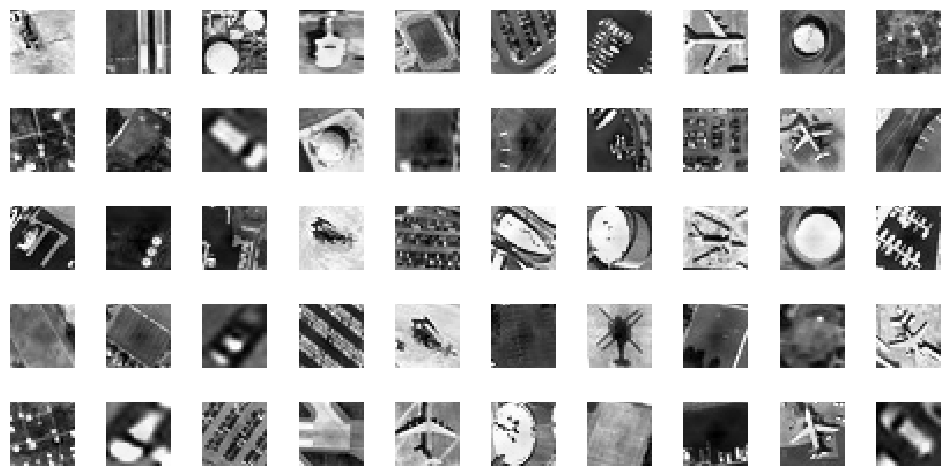

In [10]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(np.array(X_train)[index].reshape(28,28), cmap="gray", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

### Checking value counts of training and validation data

In [11]:
y_train.value_counts()

label
9    711
1    711
5    711
0    711
7    711
3    710
4    710
8    675
6    641
2    524
Name: count, dtype: int64

In [12]:
y_val.value_counts()

label
1    178
5    178
9    178
3    178
7    178
4    178
0    177
8    168
6    160
2    131
Name: count, dtype: int64

In [13]:
y_test.value_counts()

label
4    112
0    112
5    111
1    111
7    111
9    111
3    110
8    105
6    100
2     82
Name: count, dtype: int64

Coverting from Pandas DataFrame to Numpy array

In [14]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### Functions for Seeding classification process using kmeans clustering

In [15]:
from operator import itemgetter

def seed_classification_full_clusters(k = 20):
    '''
    returns the whole training data with each image 
    labelled the same as the point closest  to the center
    of the cluster to which it belongs
    '''
    # flatten the data as 2d array
    X_train_flatten = X_train.reshape(len(y_train),784)
    # Fit kmeans to the flatten data
    kmeans = KMeans(n_clusters=k).fit(X_train_flatten)
    l = {}
    # find labels for each of the k clusters
    for i in range(k):
        l[i] = y_train[np.argmin([np.linalg.norm(kmeans.cluster_centers_[i]-j) for j in X_train.reshape(len(y_train),784)])]
    pred_labels = {}
    # label each training data as per the cluster they belong to
    for i in range(len(y_train)):
        pred_labels[i] = l[kmeans.labels_[i]]
    X_train_flatten = X_train_flatten.reshape(len(y_train),28,28)
    return X_train_flatten, pred_labels.values()


def seed_classification_part(k = 20,per = 0.20):
    '''
    returns 100*per % of the training data with labels
    by labelling 100*per % closest point of each cluster to
    the center the same as the point in the cluster closest
    to the center
    '''
    # flatten the data to a 2d array
    X_train_flatten = X_train.reshape(len(y_train),784)
    # Fit Kmeans
    kmeans = KMeans(n_clusters=k).fit(X_train_flatten)
    l = {}
    out = {}
    # find labels for centers of each cluster
    for i in range(k):
        l[i] = y_train[np.argmin([np.linalg.norm(kmeans.cluster_centers_[i]-j) for j in X_train_flatten])]
    n = len(y_train)
    # the 100 per % closest points of each cluster with the same label as their center's label
    # is computed and return
    for i in range(k):
        dist = {}
        for j in range(n):
            dist[j] = np.linalg.norm(X_train_flatten[j] - kmeans.cluster_centers_[kmeans.labels_[j]])
        dist = dict(sorted(dist.items(), key = itemgetter(1))[:int(per*len(dist))])
        for point in dist.keys():
            out[point] = l[kmeans.labels_[point]] 
    X_pre = X_train_flatten[list(out.keys())]
    labels = out.values()
    X_pre = X_pre.reshape(len(out),28,28)
    return X_pre,labels


def seed_classification_centers(k = 20):
    '''
    returns the centers of each cluster and labels
    them the same as the point closest to them
    '''
    out = {}
    # flatten the data
    X_train_flatten = X_train.reshape(len(y_train),784)
    # Fit KMeans
    kmeans = KMeans(n_clusters=k).fit(X_train_flatten)
    # Find the labels for each cluster centers
    for i in range(k):
        ind = np.argmin([np.linalg.norm(kmeans.cluster_centers_[i]-j) for j in X_train_flatten])
        l = y_train[ind]
        out[ind] = l
    # Return the points closest to each cluster centers along 
    # with their labels
    x_pre = X_train_flatten[list(out.keys())]
    labels = out.values()
    x_pre = x_pre.reshape(len(out),28,28)
    return x_pre,labels
# write alternate versions of above code for other cases to seed classification

### Creating the model using the Sequential API

In [16]:
keras.backend.clear_session()

In [17]:
def create_model():
    tf.random.set_seed(42)
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=[28, 28]))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation="relu"))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dense(50, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

In [18]:
tf.random.set_seed(42)
model = keras.Sequential()
model.add(keras.layers.InputLayer(shape=[28, 28]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,160 (1.03 MB)

 Trainable params: 271,160 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

##### Compiling the model

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer="adam",
metrics=["accuracy"])

In [22]:
X_train = X_train.reshape(len(y_train),28,28)
X_val = X_val.reshape(len(y_val),28,28)
X_test = X_test.reshape(len(y_test),28,28)

### Performance by training using the whole training data (with given labels)

In [23]:
history = model.fit(X_train, y_train, epochs=20,batch_size=6000,verbose=1,
    validation_data=(X_val, y_val))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0959 - loss: 2.3013 - val_accuracy: 0.2101 - val_loss: 2.0976
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2048 - loss: 2.0930 - val_accuracy: 0.2330 - val_loss: 1.9586
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2356 - loss: 1.9568 - val_accuracy: 0.3509 - val_loss: 1.8382
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3441 - loss: 1.8428 - val_accuracy: 0.3944 - val_loss: 1.7410
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3849 - loss: 1.7468 - val_accuracy: 0.4143 - val_loss: 1.6578
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4050 - loss: 1.6617 - val_accuracy: 0.4384 - val_loss: 1.5842
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4344 - loss: 1.5885 - val_accuracy: 0.4583 - val_loss: 1.5190
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4505 - loss: 1.5261 - val_accuracy: 0.4712 - val_loss: 1.4603

In [24]:
model.evaluate(X_test,y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5824 - loss: 1.1756


[1.2109436988830566, 0.5671361684799194]

### Training with 50 samples

In [51]:
model = create_model()
model.compile(loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])
history = model.fit(X_train[:50], y_train[:50], epochs=20,batch_size=50,verbose=1,
validation_data=(X_val, y_val))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0600 - loss: 2.3187 - val_accuracy: 0.1772 - val_loss: 2.2550
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.4000 - loss: 2.0747 - val_accuracy: 0.2036 - val_loss: 2.2202
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5000 - loss: 1.9222 - val_accuracy: 0.2207 - val_loss: 2.1944
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5800 - loss: 1.7929 - val_accuracy: 0.2383 - val_loss: 2.1653
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6200 - loss: 1.6647 - val_accuracy: 0.2623 - val_loss: 2.1294
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6400 - loss: 1.5342 - val_accuracy: 0.2694 - val_loss: 2.0951
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6800 - loss: 1.4044 - val_accuracy: 0.2846 - val_loss: 2.0634
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7200 - loss: 1.2817 - val_accuracy: 0.3016 - val_loss: 2.

In [52]:
model.evaluate(X_test,y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2895 - loss: 2.2092


[2.2384865283966064, 0.2779342830181122]

### Performance with labels from Kmeans clsutering

In [27]:
from tqdm import tqdm

##### Propagate label of point closest to cluster to whole cluster

In [28]:
full = {}

In [29]:
for k in tqdm([10,20,30,40,50,60,70,80,90,100]):
    X_pred , labels = seed_classification_full_clusters(k)
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])
    history = model.fit(X_pred, np.array(list(labels)), epochs=100,
    batch_size = 2000,verbose = 0,
    validation_data=(X_val, y_val))
    full[k] = model.evaluate(X_test,y_test,verbose = 0)[1]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [05:22<00:00, 32.23s/it]


Performance for different values of K

In [30]:
pd.DataFrame(zip(full.keys(),full.values()),columns=['K','Accuracy'],index = range(1,len(full)+1))

,K,Accuracy
1,10,0.099531
2,20,0.160563
3,30,0.225352
4,40,0.222535
5,50,0.246009
6,60,0.251643
7,70,0.267606
8,80,0.253521
9,90,0.285446
10,100,0.264789


##### Train only using points closest to centers of each cluster 

In [31]:
centers = {}

In [32]:
for k in tqdm([10,20,30,40,50,60,70,80,90,100]):
    X_pred , labels = seed_classification_centers(k)
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])
    history = model.fit(X_pred, np.array(list(labels)), epochs=100,
    batch_size = 2000,verbose = 0,
    validation_data=(X_val, y_val))
    centers[k] = model.evaluate(X_test,y_test,verbose = 0)[1]

100%|██████████| 10/10 [05:03<00:00, 30.39s/it]


Performance for different values of K

In [33]:
pd.DataFrame(zip(centers.keys(),centers.values()),columns=['K','Accuracy'],index = range(1,len(centers)+1))

,K,Accuracy
1,10,0.116432
2,20,0.148357
3,30,0.176526
4,40,0.204695
5,50,0.235681
6,60,0.248826
7,70,0.240376
8,80,0.277934
9,90,0.286385
10,100,0.291080


##### Propagate label of point closest to cluster to top k% closest points to cluster center

In [34]:
part = {}

In [37]:
for k in tqdm([10,20,30,40,50,60,70,80,90,100]):
    X_pred , labels = seed_classification_part(k,0.25)
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])
    history = model.fit(X_pred, np.array(list(labels)), epochs=70,
    batch_size =2000,verbose = 0,
    validation_data=(X_val, y_val))
    part[k] = model.evaluate(X_test,y_test,verbose =0)[1]

100%|██████████| 10/10 [04:01<00:00, 24.17s/it]


Performance for different values of K

In [38]:
pd.DataFrame(zip(part.keys(),part.values()),columns=['K','Accuracy'],index = range(1,len(part)+1))

,K,Accuracy
1,10,0.099531
2,20,0.146479
3,30,0.117371
4,40,0.123944
5,50,0.170892
6,60,0.230986
7,70,0.183099
8,80,0.194366
9,90,0.240376
10,100,0.204695
